# Decision Tree Regressor

###### Imports (All imports here for cleanliness)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
%matplotlib inline
plt.style.use('seaborn')

Version Checking

In [2]:
import sklearn
import matplotlib
import sys
import scipy
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), ('Scipy', scipy), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3
Scipy Version: 0.19.1
Sklearn Version: 0.19.0


Now let's actually build our tree class, using recursion!

In [8]:
import math
import numpy as np

class decision_tree_regressor:
    
    def __init__(self, max_depth = None, criteria='std'):
        """
        Builds a decision tree to regress on the target data. The
        decision tree is built by trying to minimize the requested
        criteria at each possible split. Starting with the whole data
        the tree will try every possible split (column and value pair)
        and choose the split which results in the greatest reduction 
        of the criteria. Then for each sub-group of that split, the 
        process is repeated recursively until no more splits are possible
        or no splits cause a reductuion of the criteria.
        ---
        KWargs:
        max_depth: how many splits to allow in the tree (depth not breadth)
        criteria: what metric to use as a measure of split strength 
        ('std'= reduction of standard deviation in the data, 'mae'=
        minimize the mean error size (abs value))
        """
        self.tree = self.tree_split()
        self.data_cols = None
        self.max_depth = max_depth
        self.current_depth = 0
        self.criteria = criteria
    
    # Sub class for handling recursive nodes (only makes sense in the scope of a tree)
    class tree_split:
        """
        A sub class for handling recursive nodes. Each node will contain the value and column
        for the current split, as well as links to the resulting nodes from the split. The 
        results attribute remains empty unless the current node is a leaf. 
        """
        def __init__(self,col=-1,value=None,results=None,label=None,tb=None,fb=None):
            self.col=col # column index of criteria being tested
            self.value=value # vlaue necessary to get a true result
            self.results=results # dict of results for a branch, None for everything except endpoints
            self.tb=tb # true decision nodes 
            self.fb=fb # false decision nodes
    
    def split_data(self, X, y, colnum, value):
        """
        Returns: Two sets of data from the initial data. Set 1 contains those that passed
        the condition of data[colnum] >= value
        ----------
        Input: The dataset, the column to split on, the value on which to split
        """
        splitter = None
        if isinstance(value, int) or isinstance(value,float):
            splitter = lambda x: x[colnum] >= value
        else:
            splitter = lambda x: x[colnum] == value
        split1 = [i for i,row in enumerate(X) if splitter(row)]
        split2 = [i for i,row in enumerate(X) if not splitter(row)]
        set1X = X[split1]
        set1Y = y[split1]
        set2X = X[split2]
        set2Y = y[split2]
        return set1X, set1Y, set2X, set2Y

    def get_mean_target_value(self, data):
        """
        Returns: A dictionary of target variable counts in the data
        """
        return np.mean(data)

    def split_criteria(self, y):
        """
        Returns the criteria we're trying to minimize by splitting.
        Current options are target Mean Absolute Error (from the target 
        mean) or Standard deviation of the target.
        ---
        Input: targets in the split
        Output: Criteria
        """
        if self.criteria == 'mae':
            mu = np.mean(y)
            return np.mean(np.abs(y-mu))
        else:
            return np.std(y)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
        
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def fit(self, X, y):
        """
        Helper function to wrap the fit method. This makes sure the full nested, 
        recursively built tree gets assigned to the correct variable name and 
        persists after training.
        """
        self.tree = self._fit(X,y)
    
    def _fit(self, X, y, depth=0):
        """
        Builds the decision tree via a greedy approach, checking every possible
        branch for the best current decision. Decision strength is measured by
        information gain/score reduction. If no information gain is possible,
        sets a leaf node. Recursive calls to this method allow the nesting. If
        max_depth is met, all further nodes become leaves as well.
        ---
        Input: X (feature matrix), y (labels)
        Output: A nested tree built upon the node class."""
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
       
        if len(X) == 0: return tree_split()
        current_score = self.split_criteria(y)

        best_gain = 0.0
        best_criteria = None
        best_sets = None
        
        self.data_cols = X.shape[1]
        
        
        # Here we go through column by column and try every possible split, measuring the
        # information gain. We keep track of the best split then use that to send the split
        # data sets into the next phase of splitting.
        
        for col in range(self.data_cols):
            column_values = set(X.T[col])
            for value in column_values:
                set1, set1_y, set2, set2_y = self.split_data(X, y, col, value)
                p = float(len(set1)) / len(y)
                gain = current_score - p*self.split_criteria(set1_y) - (1-p)*self.split_criteria(set2_y)
                if gain > best_gain and len(set1_y) and len(set2_y):
                    best_gain = gain
                    best_criteria = (col, value)
                    best_sets = (np.array(set1), np.array(set1_y), np.array(set2), np.array(set2_y))
        
        # Now decide whether it's an endpoint or we need to split again.
        if (self.max_depth and depth < self.max_depth) or not self.max_depth:
            if best_gain > 0:
                self.current_depth += 1
                true_branch = self._fit(best_sets[0], best_sets[1], depth=depth+1)
                false_branch = self._fit(best_sets[2], best_sets[3], depth=depth+1)
                return self.tree_split(col=best_criteria[0], value=best_criteria[1],
                        tb=true_branch, fb=false_branch)
            else:
                return self.tree_split(results=self.get_mean_target_value(y))
        else:
            return self.tree_split(results=self.get_mean_target_value(y))

    def print_tree(self, indent="---"):
        """
        Helper function to make sure the correct tree gets printed.
        ---
        In: indent (how to show splits between nodes)
        """
        self.__original_indent = indent
        self._print_tree_(self.tree, indent)
    
    def _print_tree_(self, tree, indent):
        """
        Goes through node by node and reports the column and value used to split
        at that node. All sub-nodes are drawn in sequence below the node.
        """
        if tree.results: # if this is a end node
            print(str(tree.results))
        else:
            print('Column ' + str(tree.col)+' : '+str(tree.value)+'? ')
            # Print the branches
            print(indent+' True: ', end=' ')
            next_indent = indent+self.__original_indent
            self._print_tree_(tree.tb,indent=next_indent)
            print(indent+' False: ', end=' ')
            self._print_tree_(tree.fb,indent=next_indent)

    def predict(self, newdata):
        """
        Helper function to make sure the correct tree is used to
        make predictions. Also manages multiple rows of input data
        since the tree must predict one at a time.
        ---
        In: new data point of the same structure as the training X.
        Out: numpy array of the resulting predictions
        """
        results = []
        newdata = self.convert_to_array(newdata)
        for x in newdata:
            results.append(self._predict(x,self.tree))
        return np.array(results)
            
    def _predict(self, newdata, tree):
        """
        Uses the reusive structure of the tree to follow each split for
        a new data point. If the node is an endpoint, the available classes
        are sorted by "most common" and then the top choice is returned.
        """
        if tree.results: # if this is a end node
            return tree.results

        if isinstance(newdata[tree.col], int) or isinstance(newdata[tree.col],float):
            if newdata[tree.col] >= tree.value:
                return self._predict(newdata, tree.tb)

            else:
                return self._predict(newdata, tree.fb)
        else:
            if newdata[tree.col] == tree.value:
                return self._predict(newdata, tree.tb)
            else:
                return self._predict(newdata, tree.fb) 

    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: accuracy (float)
        """
        pred = self.predict(X)
        return np.mean((pred-y)**2)

### Actually get the data, train, test, and report accuracy

###### Silly function to generate the test data, just to keep it clean

In [9]:
def get_data():
    x = np.linspace(-10,10,300)
    y = np.sin(x)
    return x, y

In [10]:
import pandas as pd
X,y = get_data()

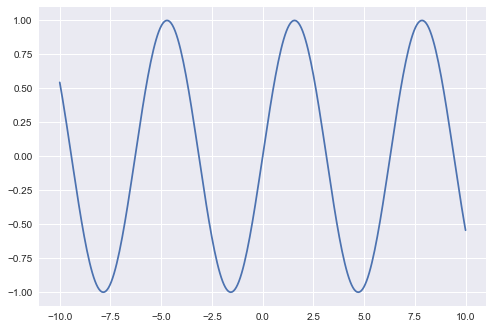

In [11]:
plt.plot(X,y);

In [12]:
dt = decision_tree_regressor(criteria='mae')
dt.fit(X,y)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
dt.data_cols

1

In [14]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    permute = np.random.permutation(len(y))
    return X[permute], y[permute]

def train_test_split_manual(X, y, test_size=0.3):
    nX, ny = shuffle_data(X,y)
    split_index = int(len(X)*test_size)
    testX = nX[:split_index]
    trainX = nX[split_index:]
    testy = ny[:split_index]
    trainy = ny[split_index:]
    return trainX, testX, trainy, testy

In [15]:
x_train, x_test, y_train, y_test = train_test_split_manual(X,y,test_size=0.3)

In [16]:
dt = decision_tree_regressor()
dt.fit(x_train,y_train)
dt.score(x_test, y_test)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.0070345618381842381

In [17]:
pred = dt.predict(x_test)
pred

array([-0.09574744, -0.09574744,  0.48478064,  0.30283269,  0.99121234,
       -0.03343858,  0.09353735, -0.23413989, -0.03565731, -0.92269318,
       -0.86302593, -0.48478064,  0.30283269, -0.53842073,  0.69078243,
       -0.74204803, -0.9805918 ,  0.64261089, -0.94349327, -0.9805918 ,
        0.92097227, -0.99753561,  0.48478064, -0.42121325,  0.89086183,
        0.78105274, -0.9805918 , -0.47699467,  0.64600652, -0.99768891,
        0.92097227, -0.99768891, -0.42724437, -0.53279647, -0.78243716,
        0.30283269, -0.74353441, -0.48478064,  0.48478064,  0.48672119,
       -0.64431029,  0.86302593,  0.36172081, -0.82357178, -0.03565731,
       -0.23413989, -0.29435762,  0.64261089,  0.36172081,  0.59532619,
        0.82608214, -0.03343858,  0.99768891,  0.92010501, -0.23413989,
        0.85964236,  0.22765971,  0.29435762, -0.22549739,  0.86077446,
        0.64261089,  0.64261089, -0.96412518, -0.48283771, -0.47894471,
       -0.48478064,  0.48478064, -0.86077446, -0.69078243,  0.48

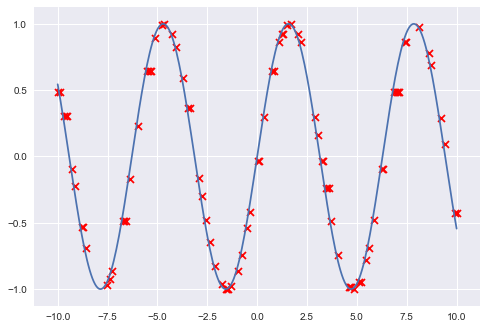

In [18]:
plt.plot(X,y)
plt.scatter(x_test,pred,c='r', marker='x');

### Let's try again, but limit the depth

In [19]:
dt2 = decision_tree_regressor(max_depth=3, criteria='mae')
dt2.fit(X,y)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


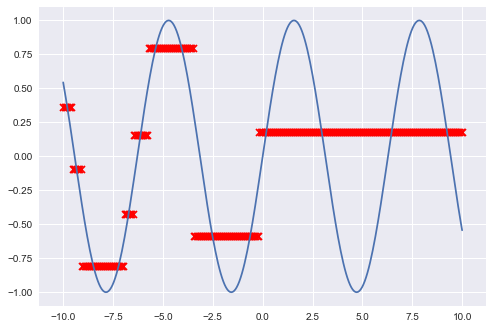

In [20]:
preds = dt2.predict(X[:])
plt.plot(X,y)
plt.scatter(X[:],preds,c='r', marker='x');

In [21]:
dt2.print_tree()

Column 0 : -6.45484949833? 
--- True:  Column 0 : -3.44481605351? 
------ True:  Column 0 : -0.167224080268? 
--------- True:  0.175948811909
--------- False:  -0.58706291535
------ False:  Column 0 : -5.71906354515? 
--------- True:  0.794399900785
--------- False:  0.158464386424
--- False:  Column 0 : -9.0635451505? 
------ True:  Column 0 : -6.92307692308? 
--------- True:  -0.421440808062
--------- False:  -0.80768520676
------ False:  Column 0 : -9.53177257525? 
--------- True:  -0.092702513385
--------- False:  0.362591374173
